# **BERTopic on Large Datasets**

Due to the modularity of BERTopic, it can also be used on large datasets (> 1_000_000) if we change some of the internal algorithms such that they can scale a bit better.

To do so, this example uses Google Colab Pro (T4 with 25GB of VRAM and 26GB of System RAM) and cuML to enable GPU-accelerated machine learning.

First, we will need to install some packages:

In [1]:
%%capture

#!pip install safetensors
%pip install datasets
%pip install datashader
%pip install adjustText

Sometimes, it might happen that you get the `NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968` error, if so make sure to run the following code:

```python
import locale
locale.getpreferredencoding = lambda: "UTF-8"
```

**(Optional)** We can mount a personal Google Drive such that we can save the resulting embeddings and models that you create. Although it is not necessary, if you created embeddings and then run into memory errors, it is generally nice to have the embeddings saved somewhere without needing to recalculate them.

# **Data**

To show how BERTopic can be used with large data, we are going to load in some Wikipedia texts. Cohere has fortunately created a dataset split by paragraphs, which allows us to stay within token limit sizes.

For this example, we load in 1 million texts from Wikipedia and see if we can extract topics from them.

In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
import json
from tqdm.auto import tqdm
import os
from nltk.corpus import stopwords
import numpy as np
import spacy

In [5]:
stopword = stopwords.words('french')
stopword += ['ouais', 'épisode', 'faire', 'morgan','prudhomme', 'lire', 'génération','podcast', 'gdiy',
           'recommande','deux','quand','the','livre', 'être','yourself', 'orso', 'doi', 'an',
           'merci', 'avoir','timeline','face','million','monde', 'vie','and','fait','abonnez', 'parce',
             'ouai', 'sai', 'it', 'do', 'mets', 'yourself','si', 'chose','oui', 'truc', 'dessus', 'traite',
             'that', 'fai', 'accord', 'gens', 'exemple', 'cosa', 'legalstart', 'start']

In [6]:
import os
import json
import spacy
from tqdm import tqdm

# Loading the static data
with open("./audio_info.json", "r") as f:
    titles = json.load(f)

stopword = set(stopword)
pos = set(['ADV', 'PRON', 'CCONJ', 'PUNCT', 'DET', 'ADP', 'SPACE', 'ADJ', 'VERB'])

def clean_up1(texts):
    return " ".join([token.lemma_ for token in texts if token.lemma_ not in stopword and token.pos_ not in pos])

def split_to_doc(file_path, spliter):
    nlp = spacy.load("fr_core_news_md")
    all_document, date = [], []
    file_list = os.listdir(file_path)

    for file in tqdm(file_list):
        with open(os.path.join(file_path, file), "r") as f:
            data = json.load(f)
            for ids, transcript in data.items():
                current_date = titles.get(ids, {}).get("date", date[-1] if
                                                       date else None)
                text = transcript["text"].lower()
                splitted_text = spliter.split_text(text)
                
                # Process the texts in batch
                docs = list(nlp.pipe(splitted_text))
                all_document.extend(clean_up1(doc) for doc in docs)
                date.extend(current_date for _ in docs)

    return all_document, date

In [8]:
import spacy
from tqdm import tqdm
import json
import os

nlp = spacy.load("fr_core_news_md")
stopword = set(stopword)  
pos = set(['ADV', 'PRON', 'CCONJ', 'PUNCT', 'DET', 'ADP', 'SPACE', 'ADJ', 'VERB'])

def clean_up1(texts, stopword, pos=None):
    
    if pos is not None:
        list_tokens = [token.lemma_ for token in texts if token.lemma_ not in stopword and token.pos_ not in pos]
    else:
        list_tokens = [token.lemma_ for token in texts if token.lemma_ not in stopword]
    return " ".join(list_tokens)

def split_to_doc(file_path, spliter):
    all_document, date = [], []
    # Load episode title
    with open("./audio_info.json", "r") as f:
        titles = json.load(f)

    for file in tqdm(os.listdir(file_path)):
        with open(file_path + file, "r") as f:
            data = json.load(f)
            for ids, transcript in data.items():
                if ids in titles:
                    current_date = titles[ids]["date"]
                else:
                    current_date = date[-1] # Use the last date if the current episode is not in the file
                text = transcript["text"].lower()
                splitted_text = spliter.split_text(text)
                
                # Process the texts in batch
                docs = nlp.pipe(splitted_text)
                for doc in docs:
                    document = clean_up1(doc, stopword=stopword, pos=pos)
                    all_document.append(document)
                    date.append(current_date)
    return all_document, date

In [9]:
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 1000,
    chunk_overlap  = 0,
    length_function = len,
)

In [10]:
doc_all = split_to_doc("../gdiy-search/gdiy_json_data/", text_splitter)

100%|██████████| 340/340 [16:00<00:00,  2.82s/it]


In [11]:
doc_all, date = doc_all 

In [12]:
doc_all

['moyenne personne mathieu stéphanie entrepreneur causa cabinet conseil stratégie croissance ensemble entrepreneur sportif artiste moyen square partenaire carré chef entreprise restaurateur besoin évolution mode paiement client vente ligne physique solution entreprise square square mot écosystème solution entreprise matériel hardware logiciel software ensemble business paiement solution point',
 'vente création boutique ligne rapport vente direct rendez-vous facture marketing endroit expérience client entreprise revenu square appareil square terminal paiement aide entreprise stock impression reçu réception paiement bonus ligne paiement temps code promo auditeur turself square.com.go.do code promo remise 40 pourcent square square',
 '40 pourcent 31 juillet limite stock square vente plaisir émission fabrice pellosi adpellosi linkedin soir fondateur directeur batch.com davlat parcours entrepreneur aventure détail entreprise 17 gestion crise 10 euro peine 30 appgratis disai numéro plaisir 

In [13]:
clean_data = {'text':doc_all, 'date':date}

In [14]:
import json
with open('./data/clean_docs.json', 'w') as f:
    json.dump(clean_data, f, indent=4)
# Extract 1 millions records
docs = doc_all; len(docs)

49892

# **Basic Example**

Now that we have our data, we can start with a basic example. This example shows the minimum steps necessary for training a BERTopic model on large datasets. Do note though that memory errors are still possible when tweaking parameters. After this section, some tips and tricks will be mentioned to demonstrate how we can further reduce memory or be more efficient with our training process.

## Embeddings

Next, we are going to pre-calculate the embeddings as input for our BERTopic model. The reason for doing this is that this input step can take quite some time to compute. If we pre-calculate them and save the resulting embeddings, we can skip over this step when we are iterating over our model.

In [15]:
# Create embeddings
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2') #'sentence-transformers/all-MiniLM-L6-v2'
embeddings = model.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/1560 [00:00<?, ?it/s]

We can save the resulting embeddings as follows:

In [16]:
with open('./embeddings.npy', 'wb') as f:
    np.save(f, embeddings)

and then load the embeddings as follows:

In [17]:
embeddings = np.load('./embeddings.npy')

## Prepare Vocab

Before we can start with training our model, there is still something that we can do to reduce the necessary memory. We can prepare our vocabulary beforehand such that the tokenizer does not need to do the calculations itself.

Below, we are essentially creating a vocabulary of words in our dataset and parsing them such that they need to appear at least 15 times in our data.

With sufficient RAM, we could skip over this step but I have found this often helps in reducing the necessary RAM.

**Note**: If you are using a custom CountVectorizer, then it is advised to use that instead of the default CountVectorizer to build the tokenizer.

In [18]:
import collections
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer

# Extract vocab to be used in BERTopic
vocab = collections.Counter()
tokenizer = CountVectorizer().build_tokenizer()
for doc in tqdm(docs):
  vocab.update(tokenizer(doc))
vocab = [word for word, frequency in vocab.items() if frequency >= 15]; len(vocab)

100%|██████████| 49892/49892 [00:00<00:00, 89022.64it/s]


6731

## Train BERTopic

Finally, we can train our BERTopic model. We select the same sentence-transformer model as we did before. Moreover, we select cuML's HDBSCAN and UMAP models. These are GPU-accelerated versions of HDBSCAN and UMAP and allow us to speed training on such a large dataset.

In [19]:
from umap import UMAP
import hdbscan
from bertopic import BERTopic

# Prepare sub-models
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
umap_model = UMAP(n_components=5, n_neighbors=50, random_state=42, metric="cosine", verbose=True)
hdbscan_model = hdbscan.HDBSCAN(min_samples=20, gen_min_span_tree=True, prediction_data=False, min_cluster_size=20)
vectorizer_model = CountVectorizer(vocabulary=vocab, stop_words=list(stopword))

# Fit BERTopic without actually performing any clustering
topic_model= BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        verbose=True
).fit(docs, embeddings=embeddings)

c:\Users\MahamadiNikiema\anaconda3\envs\podcast-env\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\MahamadiNikiema\anaconda3\envs\podcast-env\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\MahamadiNikiema\anaconda3\envs\podcast-env\lib\si

UMAP(angular_rp_forest=True, metric='cosine', n_components=5, n_neighbors=50, random_state=42, verbose=True)
Tue Oct 10 15:21:19 2023 Construct fuzzy simplicial set
Tue Oct 10 15:21:19 2023 Finding Nearest Neighbors
Tue Oct 10 15:21:19 2023 Building RP forest with 16 trees
Tue Oct 10 15:21:23 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	Stopping threshold met -- exiting after 5 iterations
Tue Oct 10 15:21:40 2023 Finished Nearest Neighbor Search
Tue Oct 10 15:21:43 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Tue Oct 10 15:22:34 2023 Finished embedding


2023-10-10 15:22:34,819 - BERTopic - Reduced dimensionality
2023-10-10 15:22:37,848 - BERTopic - Clustered reduced embeddings
c:\Users\MahamadiNikiema\anaconda3\envs\podcast-env\lib\site-packages\bertopic\vectorizers\_ctfidf.py:69: RuntimeWarning: divide by zero encountered in divide
  idf = np.log((avg_nr_samples / df)+1)


and that is it! We can inspect the topics as follows:

In [20]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,31741,-1_coup_boîte_temps_moment,"[coup, boîte, temps, moment, fois, personne, j...",[matin notion argent marché notion valeur vale...
1,0,939,0_restaurant_chef_cuisine_café,"[restaurant, chef, cuisine, café, restauration...",[fois concept restaurant partage trois suite v...
2,1,788,1_musique_album_artiste_dj,"[musique, album, artiste, dj, disque, piano, r...",[réaction musique platine chambre ado musique ...
3,2,683,2_entrepreneur_entrepreneuriat_investisseur_pr...,"[entrepreneur, entrepreneuriat, investisseur, ...",[entrepreneur besoin réussite heure cas sorte ...
4,3,566,3_moment_chance_projet_question,"[moment, chance, projet, question, temps, phas...",[test procrastination question moment moment o...
...,...,...,...,...,...
157,156,23,156_imposteur_syndrome_survie_luxe,"[imposteur, syndrome, survie, luxe, plaie, man...",[film coup chanson force mot ensemble mot ense...
158,157,22,157_cigarette_clope_tabac_liquide,"[cigarette, clope, tabac, liquide, batterie, c...",[niveau risque cigarette risque 1 2 recul ciga...
159,158,20,158_libéralisme_religion_mill_stuart,"[libéralisme, religion, mill, stuart, liberté,...",[religion historique islam contexte base 1400 ...
160,159,20,159_impression_entretien_colle_karma,"[impression, entretien, colle, karma, bête, gr...",[- bête vichy galon bouquet cerise carnet mono...


In [21]:
from datetime import datetime
date_format = [datetime.strptime(date_time, "%d/%m/%Y") for date_time in date]

In [22]:
topics =topic_model.generate_topic_labels()

In [23]:
topics_over_time = topic_model.topics_over_time(docs, date_format,
                                                global_tuning=True,
                                                evolution_tuning=True,
                                                nr_bins=20)

topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10)

20it [00:03,  6.00it/s]


Lastly, it would be advised to save the model as follows:

In [24]:
topic_model.save(
    path='../gdiy/model_dir',
    serialization="safetensors",
    save_ctfidf=True,
    save_embedding_model='sentence-transformers/all-MiniLM-L6-v2'
)

# **Advanced Tips & Tricks**

There are a number of advanced tips and tricks that you can use to make it a bit easier and more flexible to train your model at large datasets.

## UMAP

Just like we pre-computed the embeddings, we can pre-reduce the dimensionality of the embeddings with cuML's UMAP and use those.

This saves quite a bit of time since we need to reduce embeddings everytime we run BERTopic.

**NOTE**: Saving those embeddings, as we did before, is generally advised.

In [25]:
from umap import UMAP

# Train model and reduce dimensionality of embeddings
umap_model = UMAP(n_components=5, n_neighbors=15, random_state=42, 
                  metric="cosine", verbose=True)
reduced_embeddings = umap_model.fit_transform(embeddings)

UMAP(angular_rp_forest=True, metric='cosine', n_components=5, random_state=42, verbose=True)
Tue Oct 10 15:24:35 2023 Construct fuzzy simplicial set
Tue Oct 10 15:24:35 2023 Finding Nearest Neighbors
Tue Oct 10 15:24:35 2023 Building RP forest with 16 trees
Tue Oct 10 15:24:36 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	 7  /  16
	 8  /  16
	Stopping threshold met -- exiting after 8 iterations
Tue Oct 10 15:24:37 2023 Finished Nearest Neighbor Search
Tue Oct 10 15:24:38 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Tue Oct 10 15:25:15 2023 Finished embedding


Similarly, we can also prepare the UMAP-reduced embeddings for visualizing documents in 2D:

In [26]:
from umap import UMAP

# Train model and reduce dimensionality of embeddings
umap_model = UMAP(n_components=2, n_neighbors=15, random_state=42, metric="cosine", verbose=True)
reduced_embeddings_2d = umap_model.fit_transform(embeddings)

UMAP(angular_rp_forest=True, metric='cosine', random_state=42, verbose=True)
Tue Oct 10 15:25:15 2023 Construct fuzzy simplicial set
Tue Oct 10 15:25:15 2023 Finding Nearest Neighbors
Tue Oct 10 15:25:15 2023 Building RP forest with 16 trees
Tue Oct 10 15:25:16 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	 7  /  16
	 8  /  16
	Stopping threshold met -- exiting after 8 iterations
Tue Oct 10 15:25:17 2023 Finished Nearest Neighbor Search
Tue Oct 10 15:25:18 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Tue Oct 10 15:25:49 2023 Finished embedding


## HDBSCAN

We can even pre-compute the clusters with HDBSCAN and feed them to BERTopic to perform [manual topic modeling](https://maartengr.github.io/BERTopic/getting_started/manual/manual.html). Manual topic modeling with BERTopic means that if we already have labels of topics, we can use those to label them using a variety of [representation models](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html).

BERTopic can still perform inference since inference is done on topic embeddings that are created during `fit`.

In [27]:
from hdbscan import HDBSCAN

# Find clusters of semantically similar documents
hdbscan_model = HDBSCAN(min_samples=30, gen_min_span_tree=True,
                        prediction_data=False, min_cluster_size=30)
clusters = hdbscan_model.fit(reduced_embeddings).labels_

## Manual BERTopic

When we have pre-computed labels, we can pass them instead of having to calculate the clusters ourselves. This allows us to skip over the embedding, dimensionality, and clustering steps!

There is one more trick though that we are going to use. We could directly give BERTopic the reduced embeddings but BERTopic will use those to create topic vectors which is not ideal. Instead, we are giving the model the full embeddings and create a custom dimensionality reduction class that will return the reduced embeddings. This gives us the best of both worlds!

In [28]:
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer

from bertopic import BERTopic
from bertopic.cluster import BaseCluster
from bertopic.representation import KeyBERTInspired


class Dimensionality:
  """ Use this for pre-calculated reduced embeddings """
  def __init__(self, reduced_embeddings):
    self.reduced_embeddings = reduced_embeddings

  def fit(self, X):
    return self

  def transform(self, X):
    return self.reduced_embeddings


# Prepare sub-models
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
umap_model = Dimensionality(reduced_embeddings)
hdbscan_model = BaseCluster()
vectorizer_model = CountVectorizer(vocabulary=vocab, stop_words=list(stopword))
representation_model = KeyBERTInspired()

# Fit BERTopic without actually performing any clustering
topic_model= BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        representation_model=representation_model,
        verbose=True
).fit(docs, embeddings=embeddings, y=clusters)

2023-10-10 15:25:52,341 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
2023-10-10 15:25:52,341 - BERTopic - Reduced dimensionality
2023-10-10 15:25:52,352 - BERTopic - Clustered reduced embeddings
c:\Users\MahamadiNikiema\anaconda3\envs\podcast-env\lib\site-packages\bertopic\vectorizers\_ctfidf.py:69: RuntimeWarning:

divide by zero encountered in divide



In [29]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,30627,-1_problème_affaire_modèle_semaine,"[problème, affaire, modèle, semaine, personne,...",[problème trois temps concept trois jour semai...
1,0,917,0_musique_music_musicien_musical,"[musique, music, musicien, musical, instrument...",[maison disque droit droit œuvre période artis...
2,1,705,1_entrepreneur_entrepreneuriat_entrepreneurial...,"[entrepreneur, entrepreneuriat, entrepreneuria...",[entrepreneur compte final époque entrepreneur...
3,2,624,2_coup_entreprise_mission_sujet,"[coup, entreprise, mission, sujet, projet, for...",[batterie enfant famille fond besoin besoin co...
4,3,609,3_téléphone_télécommunication_télécom_téléchar...,"[téléphone, télécommunication, télécom, téléch...",[internet délai information internet besoin éc...
...,...,...,...,...,...
133,132,32,132_cigarette_époque_copain_pense,"[cigarette, époque, copain, pense, projet, réc...",[niveau risque cigarette risque 1 2 recul ciga...
134,133,32,133_fraude_audit_comportement_commerce,"[fraude, audit, comportement, commerce, scam, ...",[blague rubis enfer fraude façon fraude manièr...
135,134,32,134_âge_agence_35_quarantaine,"[âge, agence, 35, quarantaine, problème, propr...",[2014 âge âge cas envie âge cas envie envie co...
136,135,32,135_workcity_temps_plateforme_city,"[workcity, temps, plateforme, city, écoute, vo...",[bureau endroit 80 pourcent temps aventure env...


## Visualize Documents

In [30]:
import itertools
import pandas as pd

# Define colors for the visualization to iterate over
colors = itertools.cycle(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000'])
color_key = {str(topic): next(colors) for topic in set(topic_model.topics_) if topic != -1}

# Prepare dataframe and ignore outliers
df = pd.DataFrame({"x": reduced_embeddings_2d[:, 0], "y": reduced_embeddings_2d[:, 1], "Topic": [str(t) for t in topic_model.topics_]})
df["Length"] = [len(doc) for doc in docs]
df = df.loc[df.Topic != "-1"]
df = df.loc[(df.y > -10) & (df.y < 10) & (df.x < 10) & (df.x > -10), :]
df["Topic"] = df["Topic"].astype("category")

# Get centroids of clusters
mean_df = df.groupby("Topic").mean().reset_index()
mean_df.Topic = mean_df.Topic.astype(int)
mean_df = mean_df.sort_values("Topic")

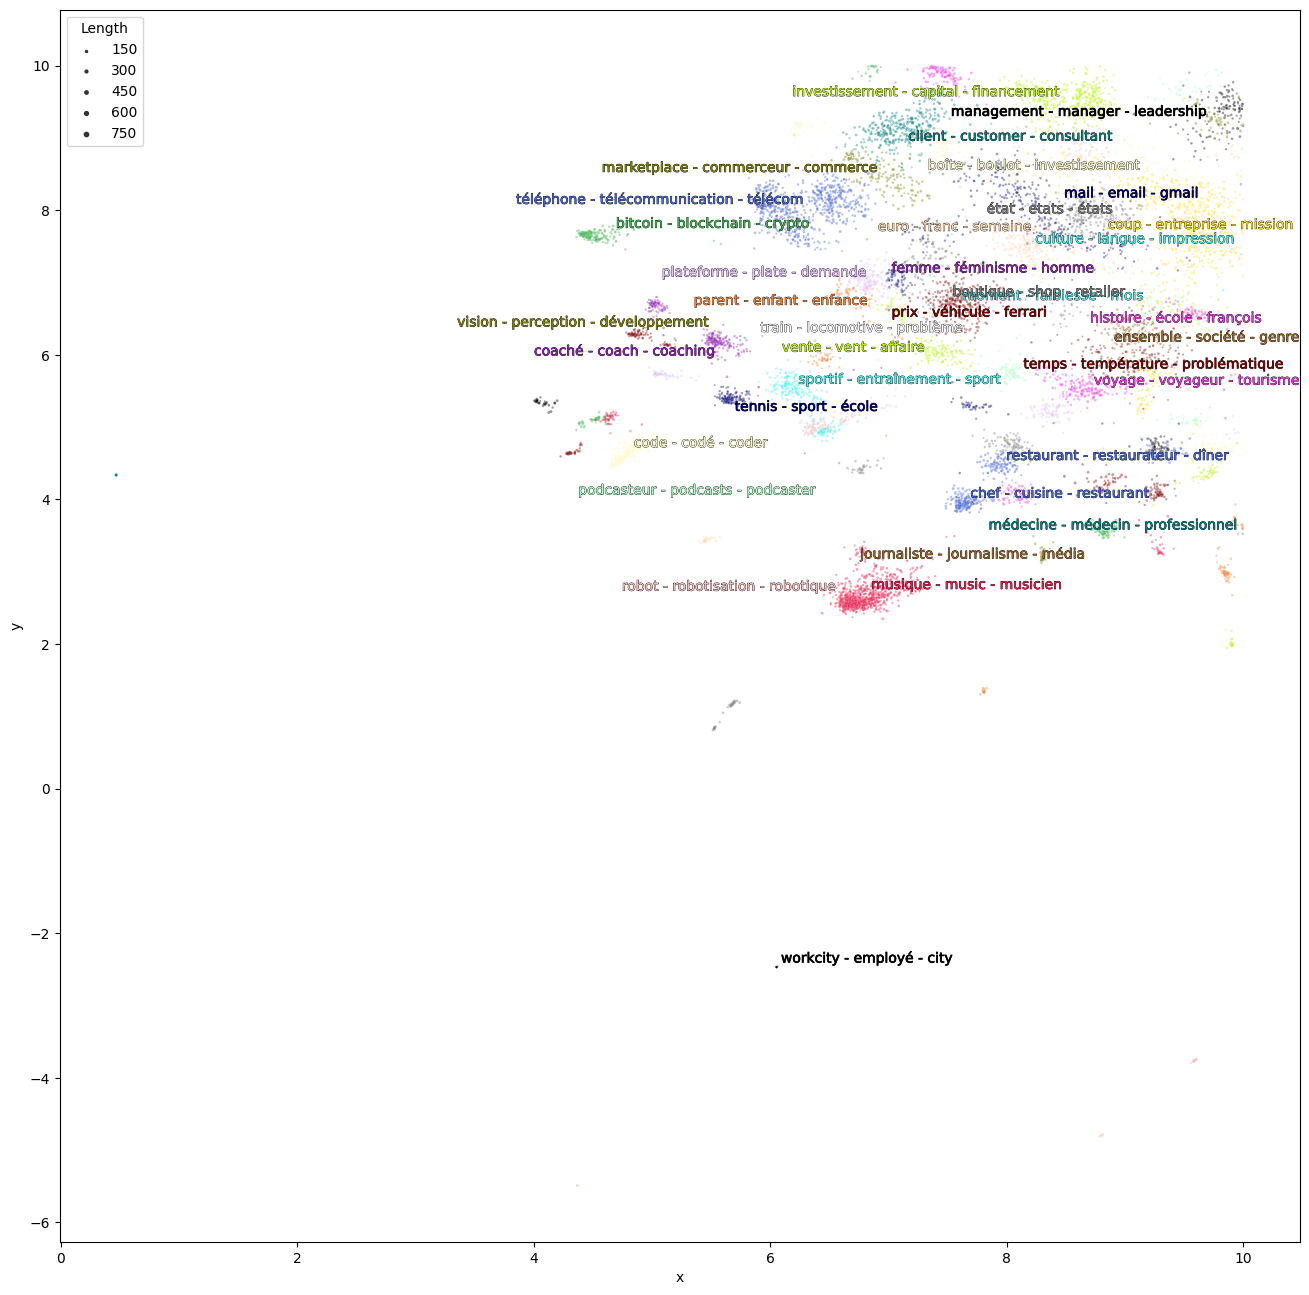

<Figure size 640x480 with 0 Axes>

In [32]:
import seaborn as sns
from matplotlib import pyplot as plt
from adjustText import adjust_text
import matplotlib.patheffects as pe

fig = plt.figure(figsize=(16, 16))
sns.scatterplot(data=df, x='x', y='y', c=df['Topic'].map(color_key), alpha=0.4, sizes=(0.4, 10), size="Length")

# Annotate top 50 topics
texts, xs, ys = [], [], []
for row in mean_df.iterrows():
  topic = row[1]["Topic"]
  name = " - ".join(list(zip(*topic_model.get_topic(int(topic))))[0][:3])

  if int(topic) <= 50:
    xs.append(row[1]["x"])
    ys.append(row[1]["y"])
    texts.append(plt.text(row[1]["x"], row[1]["y"], name, size=10, ha="center", color=color_key[str(int(topic))],
                          path_effects=[pe.withStroke(linewidth=0.5, foreground="black")]))

# Adjust annotations such that they do not overlap
adjust_text(texts, x=xs, y=ys, time_lim=1, force_text=(0.01, 0.02), force_static=(0.01, 0.02), force_pull=(0.5, 0.5))
plt.show()
plt.savefig("output.png", dpi=600)